In [1]:
from xmlrpc.client import Binary

import copick
import keras.src.losses
import pandas as pd
import zarr
from matplotlib import pyplot as plt
import os
import json
import numpy as np
from keras import layers, models
import matplotlib.patches as patches
from keras.api.losses import BinaryCrossentropy
from keras.api.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.utils.extmath import cartesian
from tensorflow.python.ops.gen_nn_ops import Conv3D, max_pool
from tqdm import tqdm
from numba import njit, prange
import datetime
import tensorflow as tf


In [2]:
def get_copick_root(split):
    """
    Loads the copick configuration based on the split.

    Args:
        split (str): 'train' or 'test'.

    Returns:
        copick_root: The loaded copick configuration.
    """
    config_path = '../../../copick_config.json' if split == 'train' else '../../../copick_config_test.json'
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Configuration file not found: {config_path}")
    copick_root = copick.from_file(config_path)
    return copick_root


In [3]:
def get_static_tomogram(run_name, split='train', tomo_type='denoised', zarr_group_idx=0):
    """
    Retrieves a static tomogram from the copick dataset.

    Args:
        run_name (str): Name of the run.
        split (str): 'train' or 'test'.
        tomo_type (str): Type of tomogram.
        zarr_group_idx (int): Index of the Zarr group.

    Returns:
        np.ndarray: The tomogram data as a NumPy array.
    """
    copick_root = get_copick_root(split)
    run = copick_root.get_run(run_name)
    voxel_spacing = run.get_voxel_spacing(10.000)
    tomogram = voxel_spacing.get_tomogram(tomo_type)
    zarr_store = tomogram.zarr()
    zarr_group = zarr.open(zarr_store, mode='r')
    try:
        tomogram_vals = zarr_group[str(zarr_group_idx)][:]  # Use string keys if necessary
    except KeyError:
        raise KeyError(f"Zarr group index {zarr_group_idx} not found in the store.")
    return tomogram_vals


In [4]:
def get_label_locations(run_name, copick_root, voxel_spacing=10):
    """
    Extracts label locations from JSON files for a given run.

    Args:
        run_name (str): Name of the run.
        copick_root: Copick root object.
        voxel_spacing (float): Voxel spacing for normalization.

    Returns:
        dict: Dictionary with particle names as keys and arrays of locations as values.
    """
    picks_folder = os.path.join(copick_root.config.overlay_root, 'ExperimentRuns', run_name, 'Picks')
    if not os.path.exists(picks_folder):
        raise FileNotFoundError(f"Picks folder not found: {picks_folder}")

    picks = {}
    for json_file in os.listdir(picks_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(picks_folder, json_file)
            with open(json_path, 'r') as file:
                pick_data = json.load(file)
            particle_name = json_file[:-5]  # Remove '.json' extension
            picks[particle_name] = np.array([
                [
                    point['location']['x'] / voxel_spacing,
                    point['location']['y'] / voxel_spacing,
                    point['location']['z'] / voxel_spacing
                ]
                for point in pick_data.get('points', [])
            ])
    return picks


In [5]:
# Load copick configurations
copick_root_train = get_copick_root('train')
copick_root_test = get_copick_root('test')


In [6]:
# Retrieve run names
training_runs = copick_root_train.runs
testing_runs = copick_root_test.runs

training_run_names = [run.name for run in training_runs]
testing_run_names = [run.name for run in testing_runs]
extra_training_run_names = list(set(training_run_names) - set(testing_run_names))

print(f'Training runs: {training_run_names}')
print(f'Testing runs: {testing_run_names}')
print(f'Extra training runs not in testing: {extra_training_run_names}')


Training runs: ['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']
Testing runs: ['TS_5_4', 'TS_69_2', 'TS_6_4']
Extra training runs not in testing: ['TS_99_9', 'TS_86_3', 'TS_73_6', 'TS_6_6']


In [7]:
# Load tomograms
tomograms_train = []
tomograms_test = []

for training_run_name in training_run_names:
    try:
        tomo = get_static_tomogram(split='train', run_name=training_run_name)
        tomograms_train.append({'run': training_run_name, 'tomogram': tomo})
    except Exception as e:
        print(f"Error loading tomogram for run {training_run_name}: {e}")

for testing_run_name in testing_run_names:
    try:
        tomo = get_static_tomogram(split='test', run_name=testing_run_name)
        tomograms_test.append({'run': testing_run_name, 'tomogram': tomo})
    except Exception as e:
        print(f"Error loading tomogram for run {testing_run_name}: {e}")

print(f'Number of train tomograms: {len(tomograms_train)}')
print(f'Number of test tomograms: {len(tomograms_test)}')


Number of train tomograms: 7
Number of test tomograms: 3


In [8]:
# Verify the loaded tomograms
if tomograms_train:
    sample_tomo = tomograms_train[0]['tomogram']
    print(f"Type: {type(sample_tomo)}")
    print(f"Element Type: {type(sample_tomo[0])}")
    print(f"Shape: {sample_tomo.shape}")
else:
    print("No training tomograms loaded.")


Type: <class 'numpy.ndarray'>
Element Type: <class 'numpy.ndarray'>
Shape: (184, 630, 630)


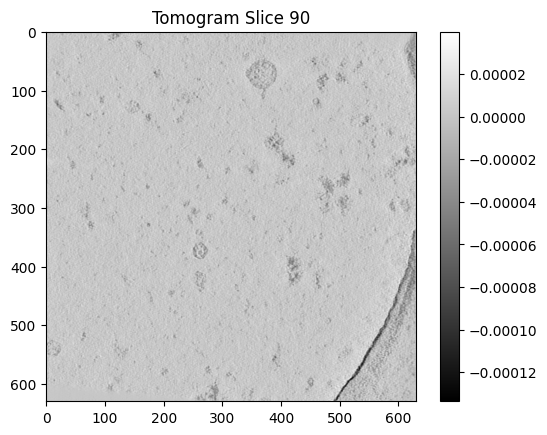

In [9]:
# Visualize a slice
if tomograms_train:
    slice_index = 90  # Adjust as needed
    if slice_index < tomograms_train[0]['tomogram'].shape[0]:
        plt.imshow(tomograms_train[0]['tomogram'][slice_index], cmap='gray')
        plt.title(f"Tomogram Slice {slice_index}")
        plt.colorbar()
        plt.show()
    else:
        print(
            f"Slice index {slice_index} out of range for tomogram with depth {tomograms_train[0]['tomogram'].shape[0]}")
else:
    print("No training tomograms to visualize.")


In [10]:
# Create DataFrame with particle locations
rows = []
for run in training_run_names:
    try:
        label_data = get_label_locations(run, copick_root_train)
        for particle, locations in label_data.items():
            matching_particles = [obj.radius for obj in copick_root_train.config.pickable_objects if
                                  obj.name == particle]
            if not matching_particles:
                print(f"No matching particle found for {particle} in run {run}")
                continue
            radius = matching_particles[0] / 10
            for location in locations:
                rows.append({
                    'run': run,
                    'particle': particle,
                    'x': location[0],
                    'y': location[1],
                    'z': location[2],
                    'radius': radius
                })
    except Exception as e:
        print(f"Error processing labels for run {run}: {e}")

particle_locations_df = pd.DataFrame(rows)
print(particle_locations_df.sample(5))
print(f"Total labeled particles: {len(particle_locations_df)}")

          run            particle         x         y         z  radius
578    TS_6_6        apo-ferritin  568.0786  275.9578   93.6164     6.0
628   TS_73_6            ribosome  561.2530  250.4846   75.7101    15.0
489    TS_6_6            ribosome  544.2264  247.3504  111.6388    15.0
1120  TS_99_9            ribosome  478.7941  145.2551   90.4813    15.0
689   TS_73_6  beta-galactosidase   83.9231  160.2692  108.8077     9.0
Total labeled particles: 1269


In [412]:
def compute_ground_truth_boxes(df):
    """
    Computes ground truth bounding boxes from particle center points and radii.

    Args:
        df (pd.DataFrame): DataFrame with columns ['run', 'particle', 'x', 'y', 'z', 'radius'].

    Returns:
        np.ndarray: Array of ground truth boxes with shape (N, 6), where each box is (x_min, y_min, z_min, x_max, y_max, z_max).
        np.ndarray: Array of corresponding particle labels (strings).
    """
    # Compute the min and max bounds for each box
    x_min = df['x'] - df['radius']
    x_max = df['x'] + df['radius']
    y_min = df['y'] - df['radius']
    y_max = df['y'] + df['radius']
    z_min = df['z'] - df['radius']
    z_max = df['z'] + df['radius']
    
    # Combine min and max bounds into a single array
    ground_truth_boxes = np.stack([x_min, y_min, z_min, x_max, y_max, z_max], axis=1)
    
   
    # Create a mapping of particle labels to integer IDs
    unique_labels = df['particle'].unique()
    label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
    id_to_label = {idx:label for label,idx in label_to_id.items()}
    
    # Encode particle labels as integers
    encoded_labels = df['particle'].map(label_to_id).values
    
    return ground_truth_boxes, encoded_labels, label_to_id,id_to_label

ground_truth_boxes,ground_truth_labels,label_to_id,id_to_label = compute_ground_truth_boxes(particle_locations_df)
print(id_to_label[ground_truth_labels[0]])
print(ground_truth_boxes[0])

ribosome
[445.1271  45.1066  45.0934 475.1271  75.1066  75.0934]


In [12]:
# Define particle types and tomogram shape
particle_types = sorted(particle_locations_df['particle'].unique())
if tomograms_train:
    tomogram_shape = tomograms_train[0]['tomogram'].shape
    print(f"Tomogram shape: {tomogram_shape}")
else:
    raise ValueError("No training tomograms available to determine shape.")

tomogram_with_channel = np.expand_dims(tomograms_train[0]['tomogram'], axis=-1)  # Add channel dimension
print(f'Tomogram With Channel Shape: {tomogram_with_channel.shape}')

Tomogram shape: (184, 630, 630)
Tomogram With Channel Shape: (184, 630, 630, 1)


In [492]:
def build_backbone(input_shape):
    inputs = keras.layers.Input(shape=input_shape)
    
    # Backbone
    x = layers.Conv3D(32,(3,3,3),activation='relu',padding='same')(inputs)
    x = layers.MaxPooling3D(pool_size=(2,2,2),padding='same')(x)
    x = layers.Conv3D(64,(3,3,3),activation='relu',padding='same')(x)
    x = layers.MaxPooling3D(pool_size=(2,2,2),padding='same')(x)
    
    model = keras.Model(inputs=inputs, outputs=x)

    return model

def build_rpn(feature_map,particles_count,number_of_anchors):
    # Shared convolutional layer
    shared = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(feature_map)
    
    # Objectness score branch
    objectness = layers.Conv3D(number_of_anchors * particles_count, (1, 1, 1), activation='sigmoid', name='objectness')(shared)
    
    # Bounding box regression branch
    bbox_regression = layers.Conv3D(number_of_anchors*6, (1, 1, 1), activation='linear', name='bbox_regression')(shared)
    
    return objectness, bbox_regression

scales = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
aspect_ratios = [(1, 1, 1)]
number_of_anchors = len(scales) * len(aspect_ratios)

backbone = build_backbone(tomogram_with_channel.shape)
feature_map = backbone.output
rpn = build_rpn(feature_map,len(particle_types),number_of_anchors)
model = keras.Model(inputs=backbone.input, outputs=rpn)
model.summary()

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 184, 630,  │          0 │ -                 │
│ (InputLayer)        │ 630, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_54 (Conv3D)  │ (None, 184, 630,  │        896 │ input_layer_18[0… │
│                     │ 630, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_36    │ (None, 92, 315,   │          0 │ conv3d_54[0][0]   │
│ (MaxPooling3D)      │ 315, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_55 (Conv3D)  │ (None, 92, 315,   │     55,360 │ max_pooling3d_36… │
│                     │ 315, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_37    │ (None, 46, 158,   │          0 │ conv3d_55[0][0]   │
│ (MaxPooling3D)      │ 158, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_56 (Conv3D)  │ (None, 46, 158,   │    442,624 │ max_pooling3d_37… │
│                     │ 158, 256)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ objectness (Conv3D) │ (None, 46, 158,   │     33,924 │ conv3d_56[0][0]   │
│                     │ 158, 132)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_regression     │ (None, 46, 158,   │     33,924 │ conv3d_56[0][0]   │
│ (Conv3D)            │ 158, 132)         │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 566,728 (2.16 MB)

 Trainable params: 566,728 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [468]:
def calculate_cumulative_stride(backbone_model):
    """
    Calculates the cumulative stride of the backbone CNN by traversing its layers.
    
    Args:
        backbone_model (keras.Model): The backbone CNN model.
    
    Returns:
        tuple: Cumulative strides along (z, y, x).
    """
    stride_z, stride_y, stride_x = 1, 1, 1
    for layer in backbone_model.layers:
        if isinstance(layer, layers.MaxPooling3D):
            pool_size = layer.pool_size  # e.g., (2, 2, 2)
            strides = layer.strides      # e.g., (2, 2, 2)
            stride_z *= strides[0]
            stride_y *= strides[1]
            stride_x *= strides[2]
    return stride_z, stride_y, stride_x

stride_z, stride_y, stride_x = calculate_cumulative_stride(backbone)
print(f"Cumulative Strides - Z: {stride_z}, Y: {stride_y}, X: {stride_x}")

Cumulative Strides - Z: 4, Y: 4, X: 4


In [469]:
def create_anchors(feature_map_shape, scales, aspect_ratios):
    """
    Generates and clips anchor boxes based on the feature map and anchor parameters.

    Args:
        feature_map_shape (tuple): Shape of the feature map (batch_size, D, H, W, C).
        voxel_spacing (float): Voxel spacing used in the tomogram.
        scales (list): List of scales.
        aspect_ratios (list of tuples): List of aspect ratios (w, h, d).

    Returns:
        np.ndarray: Array of clipped anchor boxes with shape (N, 6).
    """
    D, H, W = feature_map_shape[1], feature_map_shape[2], feature_map_shape[3]
    # Define centers based on voxel spacing and feature map stride
    centers_z = np.arange(D)
    centers_y = np.arange(H)
    centers_x = np.arange(W)
    anchor_boxes = generate_anchor_boxes_vectorized(centers_z, centers_y, centers_x, scales, aspect_ratios)
    anchor_boxes = clip_boxes(anchor_boxes, feature_map_shape)
    return anchor_boxes

def clip_boxes(anchor_boxes, input_shape):
    """
    Clips anchor boxes to lie within the input volume.

    Args:
        anchor_boxes (np.ndarray): Array of anchor boxes with shape (N, 6).
        input_shape (tuple): Shape of the input volume (D, H, W, C).

    Returns:
        np.ndarray: Clipped anchor boxes.
    """
    D_max, H_max, W_max = input_shape[1], input_shape[2], input_shape[3]
    # Clipping
    anchor_boxes[:, 0] = np.clip(anchor_boxes[:, 0], 0, W_max - 1)  # x_min
    anchor_boxes[:, 1] = np.clip(anchor_boxes[:, 1], 0, H_max - 1)  # y_min
    anchor_boxes[:, 2] = np.clip(anchor_boxes[:, 2], 0, D_max - 1)  # z_min
    anchor_boxes[:, 3] = np.clip(anchor_boxes[:, 3], 0, W_max - 1)  # x_max
    anchor_boxes[:, 4] = np.clip(anchor_boxes[:, 4], 0, H_max - 1)  # y_max
    anchor_boxes[:, 5] = np.clip(anchor_boxes[:, 5], 0, D_max - 1)  # z_max
    return anchor_boxes

def generate_anchor_boxes_vectorized(centers_z, centers_y, centers_x, scales, aspect_ratios, stride=4):
    """
    Efficiently generates anchor boxes using numpy broadcasting with correct shape alignment.
    
    Args:
        centers_z (np.ndarray): Array of center z-coordinates, shape (Nz,)
        centers_y (np.ndarray): Array of center y-coordinates, shape (Ny,)
        centers_x (np.ndarray): Array of center x-coordinates, shape (Nx,)
        scales (list): List of scales, length S
        aspect_ratios (list of tuples): List of aspect ratios (w_ratio, h_ratio, d_ratio), length R
        stride (int): Stride factor between input and feature map
    
    Returns:
        np.ndarray: Array of anchor boxes with shape (Nz * Ny * Nx * S * R, 6), 
                    where each box is (x_min, y_min, z_min, x_max, y_max, z_max)
    """
    # Convert scales and aspect_ratios to NumPy arrays
    scales = np.array(scales)  # Shape: (S,)
    aspect_ratios = np.array(aspect_ratios)  # Shape: (R, 3)
    
    num_scales = scales.shape[0]
    num_ratios = aspect_ratios.shape[0]
    num_sizes = num_scales * num_ratios
    
    # Compute all (w, h, d) combinations
    # Repeat each scale for each aspect ratio
    scales_repeated = np.repeat(scales, num_ratios)  # Shape: (S*R,)
    aspect_ratios_tiled = np.tile(aspect_ratios, (num_scales, 1))  # Shape: (S*R, 3)
    sizes = scales_repeated[:, np.newaxis] * aspect_ratios_tiled  # Shape: (S*R, 3)
    
    # Generate all combinations of center coordinates
    # Using meshgrid with 'ij' indexing to match the nested loop order: z, y, x
    zz, yy, xx = np.meshgrid(centers_z, centers_y, centers_x, indexing='ij')  # Each of shape (Nz, Ny, Nx)
    centers = np.stack([xx, yy, zz], axis=-1).reshape(-1, 3)  # Shape: (Nz*Ny*Nx, 3)
    
    # Scale centers back to input space
    # centers = centers * stride  # Assuming each feature map voxel corresponds to 'stride' in input#
    
    # Number of centers and sizes
    N = centers.shape[0]  # Nz * Ny * Nx
    M = sizes.shape[0]    # S * R
    
    # Expand dimensions to enable broadcasting
    # centers_expanded: (N, 1, 3)
    # sizes_expanded: (1, M, 3)
    centers_expanded = centers[:, np.newaxis, :]  # Shape: (N, 1, 3)
    sizes_expanded = sizes[np.newaxis, :, :]      # Shape: (1, M, 3)
    
    # Compute min and max coordinates
    mins = centers_expanded - sizes_expanded / 2.0  # Shape: (N, M, 3)
    maxs = centers_expanded + sizes_expanded / 2.0  # Shape: (N, M, 3)
    
    # Stack to get (x_min, y_min, z_min, x_max, y_max, z_max)
    anchor_boxes = np.concatenate([mins, maxs], axis=-1).reshape(-1, 6)  # Shape: (N*M, 6)
    
    return anchor_boxes

In [493]:
# Generate anchor boxes based on the feature map
voxel_spacing = 1  # Replace with actual spacing if different
print(feature_map.shape)
anchor_boxes = create_anchors(feature_map.shape, scales, aspect_ratios)
print(f"Generated {anchor_boxes.shape[0]} anchor boxes.")

(None, 46, 158, 158, 64)
Generated 25263568 anchor boxes.


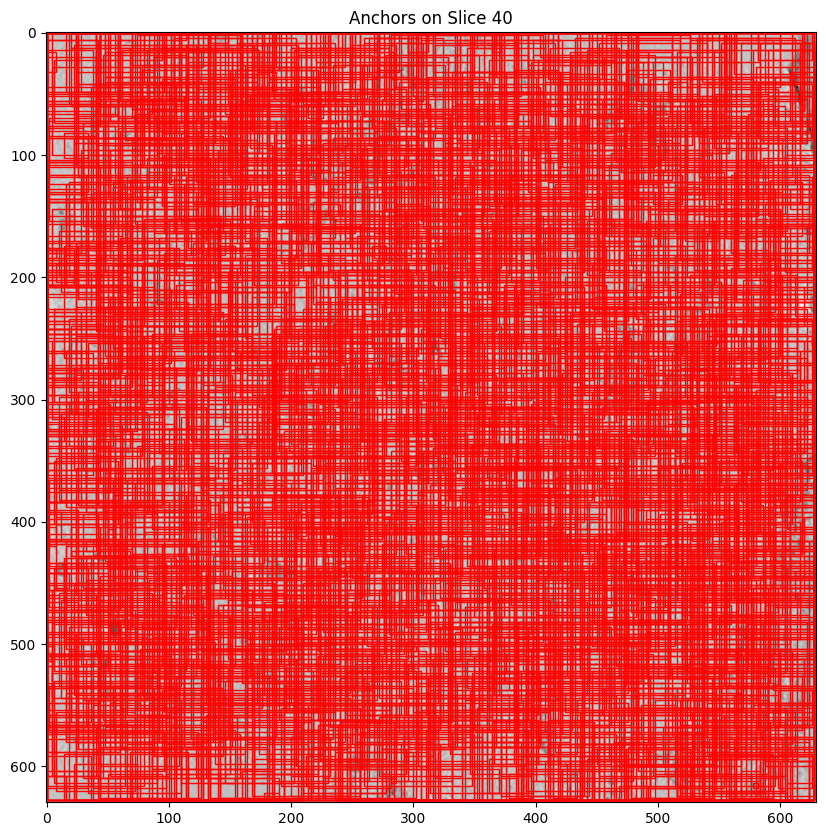

In [494]:
def visualize_anchors(tomogram, anchors, slice_index, max_anchors=100):
    """
    Visualizes a subset of anchor boxes on a specific slice of the tomogram.

    Args:
        tomogram (np.ndarray): 3D tomogram data.
        anchors (np.ndarray): Array of anchor boxes with shape (N, 6).
        slice_index (int): Index of the slice to visualize.
        max_anchors (int): Maximum number of anchors to visualize.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(tomogram[slice_index], cmap='gray')
    ax = plt.gca()
    count = 0
    
    num_boxes = anchor_boxes.shape[0]
    indices = np.random.choice(num_boxes, size=max_anchors, replace=False)
    random_anchors=anchor_boxes[indices]
    
    for anchor in random_anchors:
        x_min, y_min, z_min, x_max, y_max, z_max = anchor*4
        
        if z_min <= slice_index < z_max:
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    plt.title(f"Anchors on Slice {slice_index}")
    plt.show() 
    
# (Optional) Visualize a subset of anchors on a specific slice
if tomograms_train:
    slice_index = 40  # Adjust as needed
    visualize_anchors(tomograms_train[0]['tomogram'], anchor_boxes, slice_index, max_anchors=10000)
else:
    print("No training tomograms available for visualization.")


In [496]:
def match_anchors_optimized(anchor_boxes, ground_truth_boxes, ground_truth_labels, feature_map_shape, stride=(4,4,4), iou_thresholds=(0.3, 0.7)):
    """
    Optimized matching of anchors to ground truth boxes by focusing on anchors around each ground truth box.
    
    Args:
        anchor_boxes (np.ndarray): Array of anchor boxes with shape (N, 6).
        ground_truth_boxes (np.ndarray): Array of ground truth boxes with shape (M, 6).
        ground_truth_labels (np.ndarray): Array of ground truth labels with shape (M,).
        feature_map_shape (tuple): Shape of the feature map (batch_size, D, H, W, C).
        stride (tuple): Stride factors along (z, y, x).
        iou_thresholds (tuple): Tuple of (low_threshold, high_threshold) for negative and positive IoU.
    
    Returns:
        anchor_labels (np.ndarray): Array of labels for each anchor (-1 for ignored, 0 for background, positive int for classes).
        anchor_deltas (np.ndarray): Array of deltas (dx, dy, dz, dw, dh, dd) for each positive anchor.
        best_gt_idx (np.ndarray): Array of indices of best ground truth box for each anchor.
    """
    low_threshold, high_threshold = iou_thresholds
    num_anchors = anchor_boxes.shape[0]
    num_gt = ground_truth_boxes.shape[0]
    
    # Initialize labels and deltas
    anchor_labels = np.full(num_anchors, -1, dtype=np.int32)
    anchor_deltas = np.zeros((num_anchors, 6), dtype=np.float32)
    best_gt_idx = np.full(num_anchors, -1, dtype=np.int32)  # Initialize with -1
    
    # Iterate over each ground truth box
    for gt_idx in range(num_gt):
        gt_box = ground_truth_boxes[gt_idx]
        gt_label = ground_truth_labels[gt_idx]
        
        # Define a search window around the ground truth box
        # Adjust the multiplier based on stride and desired coverage
        multiplier = 10  # Can be tuned
        search_window = np.array([
            gt_box[0] - multiplier * stride[2],  # x_min
            gt_box[1] - multiplier * stride[1],  # y_min
            gt_box[2] - multiplier * stride[0],  # z_min
            gt_box[3] + multiplier * stride[2],  # x_max
            gt_box[4] + multiplier * stride[1],  # y_max
            gt_box[5] + multiplier * stride[0]   # z_max
        ])
        
        # Find anchors within the search window
        in_x = (anchor_boxes[:,0] >= search_window[0]) & (anchor_boxes[:,3] <= search_window[3])
        in_y = (anchor_boxes[:,1] >= search_window[1]) & (anchor_boxes[:,4] <= search_window[4])
        in_z = (anchor_boxes[:,2] >= search_window[2]) & (anchor_boxes[:,5] <= search_window[5])
        in_window = in_x & in_y & in_z
        
        # Get candidate anchors
        candidate_indices = np.where(in_window)[0]
        
        if candidate_indices.size == 0:
            continue  # No anchors in this window
        
        candidate_anchors = anchor_boxes[candidate_indices]
        
        # Compute IoUs between candidate anchors and the current ground truth box
        ious = compute_iou_3d(candidate_anchors, np.array([gt_box]))[:,0]  # Shape: (num_candidates,)
        
        # Assign positive labels
        pos_mask = ious >= high_threshold
        pos_indices_current = candidate_indices[pos_mask]
        anchor_labels[pos_indices_current] = gt_label
        best_gt_idx[pos_indices_current] = gt_idx
        
        # Assign negative labels
        neg_mask = ious < low_threshold
        neg_indices_current = candidate_indices[neg_mask]
        # Only assign background if not already assigned a positive label
        background_mask = (anchor_labels[neg_indices_current] == -1)
        anchor_labels[neg_indices_current[background_mask]] = 0
        
        # Compute deltas for positive anchors
        for anchor_idx in pos_indices_current:
            anchor_box = anchor_boxes[anchor_idx]
            anchor_deltas[anchor_idx] = compute_deltas(anchor_box, gt_box)
    
    return anchor_labels, anchor_deltas, best_gt_idx


def compute_iou_3d(boxes1, boxes2):
    """
    Efficiently computes IoU between two sets of 3D boxes.
    
    Args:
        boxes1 (np.ndarray): Array of shape (N, 6).
        boxes2 (np.ndarray): Array of shape (M, 6).
    
    Returns:
        np.ndarray: IoU matrix of shape (N, M).
    """
    # Expand dimensions for broadcasting
    boxes1 = boxes1[:, np.newaxis, :]  # (N, 1, 6)
    boxes2 = boxes2[np.newaxis, :, :]  # (1, M, 6)
    
    # Compute intersection coordinates
    x_min = np.maximum(boxes1[..., 0], boxes2[..., 0])
    y_min = np.maximum(boxes1[..., 1], boxes2[..., 1])
    z_min = np.maximum(boxes1[..., 2], boxes2[..., 2])
    x_max = np.minimum(boxes1[..., 3], boxes2[..., 3])
    y_max = np.minimum(boxes1[..., 4], boxes2[..., 4])
    z_max = np.minimum(boxes1[..., 5], boxes2[..., 5])
    
    # Compute intersection volume
    inter_w = np.maximum(0, x_max - x_min)
    inter_h = np.maximum(0, y_max - y_min)
    inter_d = np.maximum(0, z_max - z_min)
    intersection = inter_w * inter_h * inter_d
    
    # Compute volumes
    volume1 = (boxes1[..., 3] - boxes1[..., 0]) * \
              (boxes1[..., 4] - boxes1[..., 1]) * \
              (boxes1[..., 5] - boxes1[..., 2])
    volume2 = (boxes2[..., 3] - boxes2[..., 0]) * \
              (boxes2[..., 4] - boxes2[..., 1]) * \
              (boxes2[..., 5] - boxes2[..., 2])
    
    # Compute union volume
    union = volume1 + volume2 - intersection
    iou = intersection / np.maximum(union, 1e-6)  # Avoid division by zero
    
    return iou  # Shape: (N, M)

def compute_deltas(anchor_box, gt_box):
    """
    Computes the deltas (transformation parameters) to adjust an anchor box to a ground truth box.
    
    Args:
        anchor_box (np.ndarray): Anchor box coordinates (6,).
        gt_box (np.ndarray): Ground truth box coordinates (6,).
    
    Returns:
        np.ndarray: Deltas (6,).
    """
    # Anchor center and size
    x_a = (anchor_box[0] + anchor_box[3]) / 2.0
    y_a = (anchor_box[1] + anchor_box[4]) / 2.0
    z_a = (anchor_box[2] + anchor_box[5]) / 2.0
    w_a = anchor_box[3] - anchor_box[0]
    h_a = anchor_box[4] - anchor_box[1]
    d_a = anchor_box[5] - anchor_box[2]
    
    # Ground truth center and size
    x_g = (gt_box[0] + gt_box[3]) / 2.0
    y_g = (gt_box[1] + gt_box[4]) / 2.0
    z_g = (gt_box[2] + gt_box[5]) / 2.0
    w_g = gt_box[3] - gt_box[0]
    h_g = gt_box[4] - gt_box[1]
    d_g = gt_box[5] - gt_box[2]
    
    # Compute deltas
    dx = (x_g - x_a) / w_a
    dy = (y_g - y_a) / h_a
    dz = (z_g - z_a) / d_a
    dw = np.log(w_g / w_a)
    dh = np.log(h_g / h_a)
    dd = np.log(d_g / d_a)
    
    return np.array([dx, dy, dz, dw, dh, dd])



anchor_boxes_tomogram_space = anchor_boxes * np.array([stride_x, stride_y, stride_z, stride_x, stride_y, stride_z])

# Example parameters
iou_thresholds = (0.3, 0.6)  # Adjust as needed
stride = (stride_z, stride_y, stride_x)  # Replace with your actual stride values

# Perform optimized matching and capture best_gt_idx
anchor_labels, anchor_deltas, best_gt_idx = match_anchors_optimized(
    anchor_boxes=anchor_boxes_tomogram_space,
    ground_truth_boxes=ground_truth_boxes,
    ground_truth_labels=ground_truth_labels,
    feature_map_shape=feature_map.shape,
    stride=stride,
    iou_thresholds=iou_thresholds
)

# Verify the number of positive matches
num_positive = np.sum(anchor_labels > 0)
print(f"Number of positive anchors: {num_positive}")
decoded_labels = [id_to_label[label] for label in anchor_labels if label > 0]
print("Decoded matched labels:", decoded_labels)
print(len(decoded_labels))

Number of positive anchors: 5075
Decoded matched labels: ['thyroglobulin', 'ribosome', 'ribosome', 'ribosome', 'thyroglobulin', 'thyroglobulin', 'thyroglobulin', 'thyroglobulin', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'thyroglobulin', 'thyroglobulin', 'thyroglobulin', 'thyroglobulin', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'thyroglobulin', 'thyroglobulin', 'thyroglobulin', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'thyroglobulin', 'thyroglobulin', 'thyroglobulin', 'thyroglobulin', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'ribosome', 'apo-ferritin', 'ribosome', 'ribosome', 'ribosome', 'beta-galactosidase', 'beta-galactosidase'

In [476]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_tomogram_with_matches(tomogram, anchors, anchor_labels, best_gt_idx, ground_truth_boxes, ground_truth_labels, slice_index, id_to_label, max_anchors=100):
    """
    Plots a tomogram slice with matched anchors and their corresponding ground truth boxes overlaid.

    Args:
        tomogram (np.ndarray): 3D tomogram data of shape (D, H, W).
        anchors (np.ndarray): Array of anchor boxes with shape (N, 6).
        anchor_labels (np.ndarray): Array of labels for each anchor (-1, 0, positive int).
        best_gt_idx (np.ndarray): Array of indices of best ground truth box for each anchor.
        ground_truth_boxes (np.ndarray): Array of ground truth boxes with shape (M, 6).
        ground_truth_labels (np.ndarray): Array of ground truth labels with shape (M,).
        slice_index (int): Index of the slice to visualize along the z-axis.
        id_to_label (dict): Mapping of integer IDs to particle labels.
        max_anchors (int): Maximum number of anchors to plot to avoid clutter.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the tomogram slice
    ax.imshow(tomogram[slice_index], cmap='gray')
    ax.set_title(f"Tomogram Slice {slice_index}")
    
    # Filter positive anchors that overlap the slice
    pos_indices = np.where((anchor_labels > 0) & 
                           (anchors[:, 2] <= slice_index) & 
                           (anchors[:, 5] > slice_index))[0]
    
    # Check if there are any positive anchors
    if len(pos_indices) == 0:
        print("No positive anchors found for this slice.")
        ax.axis('off')
        plt.show()
        return
    
    # Limit the number of anchors to plot
    if len(pos_indices) > max_anchors:
        selected_indices = np.random.choice(pos_indices, size=max_anchors, replace=False)
    else:
        selected_indices = pos_indices
    
    # To avoid duplicate labels in legend
    plotted_labels = set()
    
    for i in selected_indices:
        anchor = anchors[i]
        label = anchor_labels[i]
        gt_idx = best_gt_idx[i]
        
        # Decode label to its original particle type
        particle_type = id_to_label.get(label, "Unknown")
        
        # Draw anchor box
        x_min, y_min, z_min, x_max, y_max, z_max = anchor
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1.5, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
        # Draw the corresponding ground truth box if it overlaps the slice
        gt_box = ground_truth_boxes[gt_idx]
        gt_x_min, gt_y_min, gt_z_min, gt_x_max, gt_y_max, gt_z_max = gt_box
        if gt_z_min <= slice_index <= gt_z_max:
            gt_width = gt_x_max - gt_x_min
            gt_height = gt_y_max - gt_y_min
            gt_rect = patches.Rectangle((gt_x_min, gt_y_min), gt_width, gt_height, linewidth=1.5, edgecolor='blue', facecolor='none', linestyle='--')
            ax.add_patch(gt_rect)
            
            # Annotate the particle type near the ground truth box
            ax.text(gt_x_min, gt_y_min - 5, particle_type, color='white', fontsize=8, backgroundcolor='black')
    
    # Create legend entries only once
    if len(selected_indices) > 0:
        anchor_patch = patches.Patch(edgecolor='red', facecolor='none', label='Matched Anchor')
        gt_patch = patches.Patch(edgecolor='blue', facecolor='none', linestyle='--', label='Ground Truth')
        ax.legend(handles=[anchor_patch, gt_patch])
    
    ax.axis('off')
    plt.show()

In [477]:
# Ensure 'id_to_label' is correctly defined based on 'label_to_id'
print(id_to_label) 

{0: 'virus-like-particle', 1: 'beta-galactosidase', 2: 'beta-amylase', 3: 'apo-ferritin', 4: 'thyroglobulin', 5: 'ribosome'}


In [478]:

# # Choose a slice to visualize
# slice_index = 50  # Adjust based on your tomogram's depth
# 
# # Perform optimized matching and capture all outputs
# anchor_labels, anchor_deltas, best_gt_idx = match_anchors_optimized(
#     anchor_boxes=anchor_boxes_tomogram_space,
#     ground_truth_boxes=ground_truth_boxes,
#     ground_truth_labels=ground_truth_labels,
#     feature_map_shape=feature_map.shape,
#     stride=stride,
#     iou_thresholds=iou_thresholds
# )
# 
# # Verify the number of positive matches
# num_positive = np.sum(anchor_labels > 0)
# print(f"Number of positive anchors: {num_positive}")
# 
# # Call the visualization function with positive anchors
# plot_tomogram_with_matches(
#     tomogram=tomograms_train[0]['tomogram'],
#     anchors=anchor_boxes_tomogram_space,
#     anchor_labels=anchor_labels,
#     best_gt_idx=best_gt_idx,
#     ground_truth_boxes=ground_truth_boxes,
#     ground_truth_labels=ground_truth_labels,
#     slice_index=slice_index,
#     id_to_label=id_to_label,
#     max_anchors=10  # Set to a manageable number to avoid clutter
# )



KeyboardInterrupt



In [480]:
particle_locations_df[particle_locations_df['particle']=='apo-ferritin']['radius']

64      6.0
65      6.0
66      6.0
67      6.0
68      6.0
       ... 
1215    6.0
1216    6.0
1217    6.0
1218    6.0
1219    6.0
Name: radius, Length: 375, dtype: float64

In [481]:
particle_locations_df[particle_locations_df['radius']>5]

,run,particle,x,y,z,radius
0,TS_5_4,ribosome,460.1271,60.1066,60.0934,15.0
1,TS_5_4,ribosome,480.3789,45.5425,51.4016,15.0
2,TS_5_4,ribosome,471.5436,82.5374,80.2166,15.0
3,TS_5_4,ribosome,500.3275,78.2745,80.2480,15.0
4,TS_5_4,ribosome,71.0459,381.5845,140.5435,15.0
...,...,...,...,...,...,...
1264,TS_99_9,thyroglobulin,279.0000,394.5000,79.0000,13.0
1265,TS_99_9,thyroglobulin,111.0308,573.4615,86.2154,13.0
1266,TS_99_9,thyroglobulin,314.8098,323.4683,95.2634,13.0
1267,TS_99_9,thyroglobulin,154.1778,408.2630,98.9996,13.0


In [483]:
def compute_iou_per_anchor(anchor_box, gt_box):
    """
    Computes IoU between a single anchor box and a single ground truth box.
    
    Args:
        anchor_box (np.ndarray): Anchor box coordinates (6,).
        gt_box (np.ndarray): Ground truth box coordinates (6,).
    
    Returns:
        float: IoU value.
    """
    # Compute intersection coordinates
    x_min_inter = max(anchor_box[0], gt_box[0])
    y_min_inter = max(anchor_box[1], gt_box[1])
    z_min_inter = max(anchor_box[2], gt_box[2])
    x_max_inter = min(anchor_box[3], gt_box[3])
    y_max_inter = min(anchor_box[4], gt_box[4])
    z_max_inter = min(anchor_box[5], gt_box[5])
    
    # Compute intersection volume
    inter_w = max(0, x_max_inter - x_min_inter)
    inter_h = max(0, y_max_inter - y_min_inter)
    inter_d = max(0, z_max_inter - z_min_inter)
    intersection = inter_w * inter_h * inter_d
    
    # Compute volumes
    volume_anchor = (anchor_box[3] - anchor_box[0]) * \
                    (anchor_box[4] - anchor_box[1]) * \
                    (anchor_box[5] - anchor_box[2])
    volume_gt = (gt_box[3] - gt_box[0]) * \
               (gt_box[4] - gt_box[1]) * \
               (gt_box[5] - gt_box[2])
    
    # Compute union volume
    union = volume_anchor + volume_gt - intersection
    iou = intersection / max(union, 1e-6)  # Avoid division by zero
    
    return iou

def analyze_iou_distribution_memory_efficient(anchor_labels, ground_truth_labels, best_gt_idx, ground_truth_boxes, particle_type='ribosome'):
    """
    Plots the IoU distribution for a specified particle type in a memory-efficient manner.
    
    Args:
        anchor_labels (np.ndarray): Array of labels for each anchor.
        ground_truth_labels (np.ndarray): Array of ground truth labels.
        best_gt_idx (np.ndarray): Array of indices of best ground truth box for each anchor.
        ground_truth_boxes (np.ndarray): Array of ground truth boxes.
        particle_type (str): The particle type to analyze.
    """
    # Find the label ID for the specified particle type
    particle_id = None
    for key, value in id_to_label.items():
        if value.lower() == particle_type.lower():
            particle_id = key
            break
    
    if particle_id is None:
        print(f"Particle type '{particle_type}' not found in 'id_to_label' mapping.")
        return
    
    # Find anchors matched to this particle type
    matched_indices = np.where(anchor_labels == particle_id)[0]
    print(f"Number of anchors matched to '{particle_type}': {len(matched_indices)}")
    
    if len(matched_indices) == 0:
        print(f"No anchors matched to '{particle_type}'.")
        return
    
    # Initialize list to store IoUs
    ious = []
    
    # Iterate over matched anchors and compute IoU with their assigned ground truth box
    for idx in tqdm(matched_indices, desc=f"Computing IoUs for '{particle_type}'"):
        anchor_box = anchor_boxes_tomogram_space[idx]
        gt_idx = best_gt_idx[idx]
        gt_box = ground_truth_boxes[gt_idx]
        iou = compute_iou_per_anchor(anchor_box, gt_box)
        ious.append(iou)
    
    ious = np.array(ious)
    
    # Plot IoU distribution
    plt.figure(figsize=(8, 6))
    plt.hist(ious, bins=50, range=(0, 1), color='green', alpha=0.7)
    plt.title(f"IoU Distribution for '{particle_type}' Anchors")
    plt.xlabel("IoU")
    plt.ylabel("Number of Anchors")
    plt.show()
    
    # Print statistics
    print(f"IoU Mean: {ious.mean():.3f}, IoU Std: {ious.std():.3f}, Max IoU: {ious.max():.3f}")


def count_positive_anchors_per_particle(anchor_labels, id_to_label):
    """
    Counts the number of positive anchors per particle type.
    
    Args:
        anchor_labels (np.ndarray): Array of labels for each anchor.
        id_to_label (dict): Mapping of integer IDs to particle labels.
    
    Returns:
        dict: Dictionary with particle types as keys and counts as values.
    """
    positive_indices = np.where(anchor_labels > 0)[0]
    positive_labels = anchor_labels[positive_indices]
    
    unique, counts = np.unique(positive_labels, return_counts=True)
    counts_dict = {id_to_label[uid]: count for uid, count in zip(unique, counts)}
    
    return counts_dict

# Count positive anchors per particle type
positive_anchor_counts = count_positive_anchors_per_particle(anchor_labels, id_to_label)
print("Positive Anchor Counts per Particle Type:")
for particle, count in positive_anchor_counts.items():
    print(f"{particle}: {count}")


# 
# # Suggest adding larger scales to cover ribosomes
# new_scales = [6, 9, 13, 15, 18, 21]  # Added 18 and 21
# aspect_ratios = [(1, 1, 1)]  # Assuming cubic particles
# 
# # Regenerate anchor boxes with new scales
# anchor_boxes_new = generate_anchor_boxes_vectorized(
#     centers_z=np.arange(feature_map.shape[1]),
#     centers_y=np.arange(feature_map.shape[2]),
#     centers_x=np.arange(feature_map.shape[3]),
#     scales=new_scales,
#     aspect_ratios=aspect_ratios,
#     stride=4  # Replace with your actual stride if different
# )

# # Clip boxes to tomogram dimensions
# anchor_boxes_new = clip_boxes(anchor_boxes_new, feature_map.shape)

# print(f"Original number of anchors: {anchor_boxes.shape[0]}")
# print(f"New number of anchors with added scales: {anchor_boxes_new.shape[0]}")
# 
# # Scale anchors to tomogram space (ensure it's done only once)
# anchor_boxes_new_tomogram_space = anchor_boxes_new  # If already scaled
# 
# # Perform matching with new anchors
# anchor_labels_new, anchor_deltas_new, best_gt_idx_new = match_anchors_optimized(
#     anchor_boxes=anchor_boxes_new_tomogram_space,
#     ground_truth_boxes=ground_truth_boxes,
#     ground_truth_labels=ground_truth_labels,
#     feature_map_shape=feature_map.shape,
#     stride=stride,
#     iou_thresholds=(0.3, 0.6)  # Adjust as needed
# )

# # Recount positive anchors
# positive_anchor_counts_new = count_positive_anchors_per_particle(anchor_labels_new, id_to_label)
# print("Positive Anchor Counts per Particle Type after Adding Larger Scales:")
# for particle, count in positive_anchor_counts_new.items():
#     print(f"{particle}: {count}")
# 
# # Visualize again
# plot_tomogram_with_matches(
#     tomogram=tomograms_train[0]['tomogram'],
#     anchors=anchor_boxes_new_tomogram_space,
#     anchor_labels=anchor_labels_new,
#     best_gt_idx=best_gt_idx_new,
#     ground_truth_boxes=ground_truth_boxes,
#     ground_truth_labels=ground_truth_labels,
#     slice_index=slice_index,
#     id_to_label=id_to_label,
#     max_anchors=100
# )

# 
# 
# from sklearn.utils import resample
# 
# # Separate ribosomes and VLPs
# ribosome_df = particle_locations_df[particle_locations_df['particle'] == 'ribosome']
# vlp_df = particle_locations_df[particle_locations_df['particle'] == 'virus-like-particle']  # Replace with actual label name
# 
# # Upsample or downsample to balance
# ribosome_upsampled = resample(ribosome_df, replace=True, n_samples=len(vlp_df), random_state=42)
# balanced_df = pd.concat([vlp_df, ribosome_upsampled])
# 
# # Recompute ground truth boxes and labels
# ground_truth_boxes_balanced, ground_truth_labels_balanced, label_to_id_balanced, id_to_label_balanced = compute_ground_truth_boxes(balanced_df)
# 

# # Analyze IoU distribution for ribosomes
# analyze_iou_distribution_memory_efficient(
#     anchor_labels=anchor_labels_new,
#     ground_truth_labels=ground_truth_labels_balanced,  # If you've balanced the dataset
#     best_gt_idx=best_gt_idx_new,
#     ground_truth_boxes=ground_truth_boxes_balanced,    # If you've balanced the dataset
#     particle_type='ribosome'
# )
# 
# # Similarly, analyze for VLPs
# analyze_iou_distribution_memory_efficient(
#     anchor_labels=anchor_labels_new,
#     ground_truth_labels=ground_truth_labels_balanced,  # If you've balanced the dataset
#     best_gt_idx=best_gt_idx_new,
#     ground_truth_boxes=ground_truth_boxes_balanced,    # If you've balanced the dataset
#     particle_type='virus-like-particle'  # Replace with your actual label name
# )


Positive Anchor Counts per Particle Type:
beta-galactosidase: 5419
beta-amylase: 1063
apo-ferritin: 245
thyroglobulin: 670
ribosome: 10193
Original number of anchors: 17225160
New number of anchors with added scales: 6890064


KeyboardInterrupt: 

Total ribosome ground truth boxes: 331
Ground Truth 0 (virus-like-particle) has 14 anchors assigned.
  Best anchor idx: 8292797, IoU: 0.8239746093750002
Ground Truth 1 (virus-like-particle) has 20 anchors assigned.
  Best anchor idx: 7180587, IoU: 0.7971960157865065


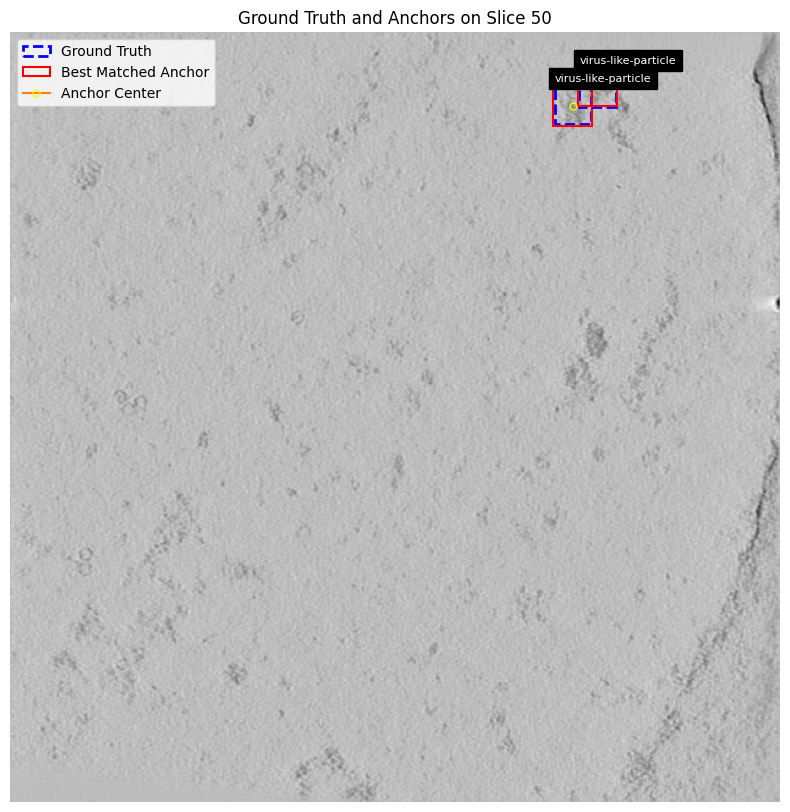

In [497]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

def compute_iou_per_anchor(anchor_box, gt_box):
    """
    Computes IoU between a single anchor box and a single ground truth box.
    
    Args:
        anchor_box (np.ndarray): Anchor box coordinates (6,).
        gt_box (np.ndarray): Ground truth box coordinates (6,).
    
    Returns:
        float: IoU value.
    """
    # Compute intersection coordinates
    x_min_inter = max(anchor_box[0], gt_box[0])
    y_min_inter = max(anchor_box[1], gt_box[1])
    z_min_inter = max(anchor_box[2], gt_box[2])
    x_max_inter = min(anchor_box[3], gt_box[3])
    y_max_inter = min(anchor_box[4], gt_box[4])
    z_max_inter = min(anchor_box[5], gt_box[5])
    
    # Compute intersection volume
    inter_w = max(0, x_max_inter - x_min_inter)
    inter_h = max(0, y_max_inter - y_min_inter)
    inter_d = max(0, z_max_inter - z_min_inter)
    intersection = inter_w * inter_h * inter_d
    
    # Compute volumes
    volume_anchor = (anchor_box[3] - anchor_box[0]) * \
                    (anchor_box[4] - anchor_box[1]) * \
                    (anchor_box[5] - anchor_box[2])
    volume_gt = (gt_box[3] - gt_box[0]) * \
               (gt_box[4] - gt_box[1]) * \
               (gt_box[5] - gt_box[2])
    
    # Compute union volume
    union = volume_anchor + volume_gt - intersection
    iou = intersection / max(union, 1e-6)  # Avoid division by zero
    
    return iou

def visualize_specific_gt_with_anchors(tomogram, anchor_boxes, anchor_labels, best_gt_idx, ground_truth_boxes, ground_truth_labels, id_to_label, gt_indices, slice_index=50, max_anchors=100):
    """
    Visualizes specific ground truth boxes and their matched anchors on a tomogram slice.

    Args:
        tomogram (np.ndarray): 3D tomogram data.
        anchor_boxes (np.ndarray): Array of anchor boxes with shape (N, 6).
        anchor_labels (np.ndarray): Array of labels for each anchor.
        best_gt_idx (np.ndarray): Array of indices of best ground truth box for each anchor.
        ground_truth_boxes (np.ndarray): Array of ground truth boxes with shape (M, 6).
        ground_truth_labels (np.ndarray): Array of ground truth labels.
        id_to_label (dict): Mapping of integer IDs to particle labels.
        gt_indices (list): List of ground truth indices to visualize.
        slice_index (int): Slice index to visualize.
        max_anchors (int): Maximum number of anchors to plot per ground truth.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(tomogram[slice_index], cmap='gray')
    ax.set_title(f"Ground Truth and Anchors on Slice {slice_index}")

    for gt_idx in gt_indices:
        gt_box = ground_truth_boxes[gt_idx]
        gt_label = ground_truth_labels[gt_idx]
        particle_type = id_to_label.get(gt_label, "Unknown")

        # Plot ground truth box if it overlaps with the slice
        if gt_box[2] <= slice_index <= gt_box[5]:
            x_min, y_min, z_min, x_max, y_max, z_max = gt_box
            width = x_max - x_min
            height = y_max - y_min
            gt_rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='blue', facecolor='none', linestyle='--', label='Ground Truth')
            ax.add_patch(gt_rect)
            ax.text(x_min, y_min - 5, particle_type, color='white', fontsize=8, backgroundcolor='black')

            # Find anchors assigned to this ground truth box
            assigned_anchors = np.where(best_gt_idx == gt_idx)[0]
            print(f"Ground Truth {gt_idx} ({particle_type}) has {len(assigned_anchors)} anchors assigned.")

            if len(assigned_anchors) == 0:
                print(f"  No anchors assigned to this ground truth.")
                continue

            # Compute IoUs
            ious = []
            for anchor_idx in assigned_anchors[:1000]:  # Limit for speed
                anchor_box = anchor_boxes[anchor_idx]
                iou = compute_iou_per_anchor(anchor_box, gt_box)
                ious.append(iou)
            ious = np.array(ious)

            if len(ious) == 0:
                print(f"  No IoUs computed for assigned anchors.")
                continue

            # Select the anchor with the highest IoU
            best_anchor_idx = assigned_anchors[np.argmax(ious)]
            best_iou = ious.max()
            print(f"  Best anchor idx: {best_anchor_idx}, IoU: {best_iou}")

            # Plot the best anchor box
            best_anchor_box = anchor_boxes[best_anchor_idx]
            x_min_a, y_min_a, z_min_a, x_max_a, y_max_a, z_max_a = best_anchor_box
            width_a = x_max_a - x_min_a
            height_a = y_max_a - y_min_a
            rect_a = patches.Rectangle((x_min_a, y_min_a), width_a, height_a, linewidth=1.5, edgecolor='red', facecolor='none', linestyle='-', label='Best Matched Anchor')
            ax.add_patch(rect_a)

            # Plot the center point of the anchor
            center_x = (x_min_a + x_max_a) / 2.0
            center_y = (y_min_a + y_max_a) / 2.0
            ax.plot(center_x, center_y, marker='o', markersize=5, markeredgecolor='yellow', markerfacecolor='none', label='Anchor Center')

    # Create legend without duplicates
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    ax.axis('off')
    plt.show()

# Example Usage:

# Identify the label ID for ribosomes
ribosome_label = 'ribosome'  # Ensure this matches exactly with your dataset
ribosome_id = label_to_id.get(ribosome_label, None)
if ribosome_id is None:
    print(f"Ribosome label '{ribosome_label}' not found in 'label_to_id' mapping.")
else:
    # Find all ground truth indices for ribosomes
    ribosome_gt_indices = np.where(ground_truth_labels == ribosome_id)[0]
    print(f"Total ribosome ground truth boxes: {len(ribosome_gt_indices)}")

    # Select a few ribosome ground truth boxes to visualize
    gt_indices_to_visualize = ribosome_gt_indices[:3]  # Adjust as needed

    visualize_specific_gt_with_anchors(
        tomogram=tomograms_train[0]['tomogram'],
        anchor_boxes=anchor_boxes_tomogram_space,
        anchor_labels=anchor_labels,
        best_gt_idx=best_gt_idx,
        ground_truth_boxes=ground_truth_boxes,
        ground_truth_labels=ground_truth_labels,
        id_to_label=id_to_label,
        gt_indices=gt_indices_to_visualize,
        slice_index=50,  # Adjust based on tomogram depth
        max_anchors=1     # Only plot the best anchor per ground truth
    )


In [498]:
new_df = pd.DataFrame(anchor_boxes_tomogram_space)

filtered_df = new_df[(new_df.iloc[:,2] < 50) & (new_df.iloc[:,5] > 50)]

In [499]:
filtered_df

,0,1,2,3,4,5
1098437,0.0,0.0,0.0,44.0,44.0,52.0
1098459,0.0,0.0,0.0,48.0,44.0,52.0
1098481,0.0,0.0,0.0,52.0,44.0,52.0
1098503,0.0,0.0,0.0,56.0,44.0,52.0
1098525,0.0,0.0,0.0,60.0,44.0,52.0
...,...,...,...,...,...,...
13180903,568.0,584.0,48.0,628.0,628.0,136.0
13180925,572.0,584.0,48.0,628.0,628.0,136.0
13180947,576.0,584.0,48.0,628.0,628.0,136.0
13180969,580.0,584.0,48.0,628.0,628.0,136.0


Total ribosome ground truth boxes: 1269
0/50 IOU: 0.5495198776793919
1/50 IOU: 0.565027680196223
2/50 IOU: 0.804651927744188
3/50 IOU: 0.5298054096491389
4/50 IOU: 0.5556638509594036
5/50 IOU: 0.5182629518281064
6/50 IOU: 0.5836676773554668
7/50 IOU: 0.5111434274078234
8/50 IOU: 0.5096403185588588


KeyboardInterrupt: 

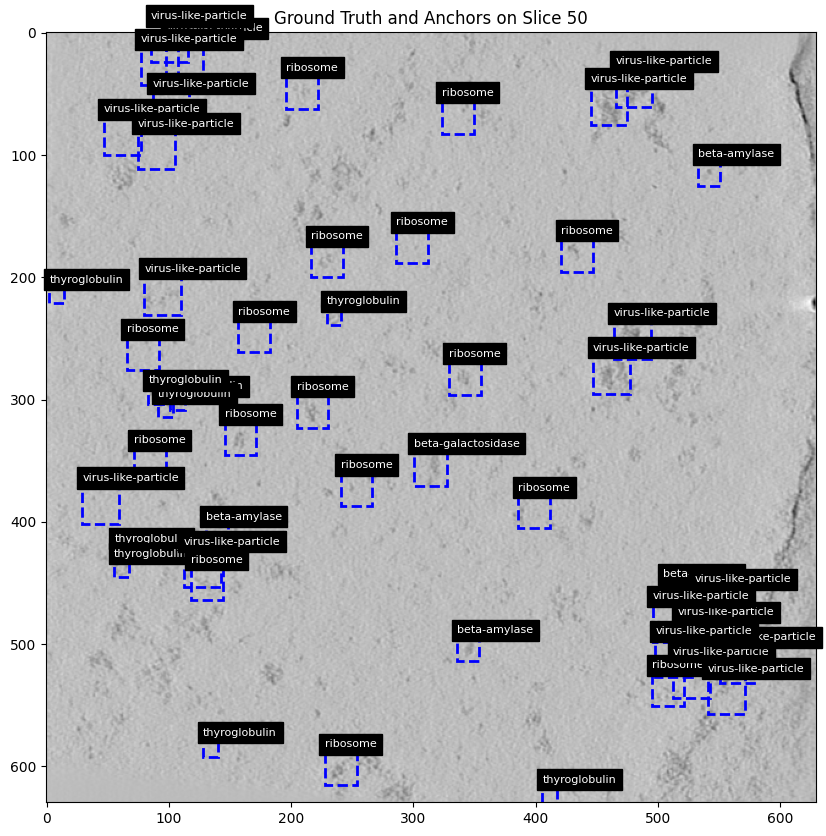

In [487]:
# # Identify the label ID for ribosomes
# ribosome_label = 'ribosome'  # Ensure this matches exactly with your dataset
# ribosome_id = label_to_id.get(ribosome_label, None)
# # Find all ground truth indices for ribosomes
# ribosome_gt_indices =ground_truth_labels# np.where(ground_truth_labels == ribosome_id)[0]
# print(f"Total ribosome ground truth boxes: {len(ribosome_gt_indices)}")
# 
# slice_index=50
# 
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(tomograms_train[0]['tomogram'][slice_index], cmap='gray')
# ax.set_title(f"Ground Truth and Anchors on Slice {slice_index}")
# 
# max_detected=50
# 
# particle_boxes=[]
# plotted_number = 0
# for gt_idx,gt_label in enumerate(ground_truth_labels):
#     gt_box = ground_truth_boxes[gt_idx]
#     particle_type = id_to_label.get(gt_label, "Unknown")
#     # Plot ground truth box if it overlaps with the slice
#     if gt_box[2] <= slice_index <= gt_box[5]:
#         particle_boxes.append(gt_box)
#         x_min, y_min, z_min, x_max, y_max, z_max = gt_box
#         width = x_max - x_min
#         height = y_max - y_min
#         gt_rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='blue', facecolor='none', linestyle='--', label='Ground Truth')
#         ax.add_patch(gt_rect)
#         ax.text(x_min, y_min - 5, particle_type, color='white', fontsize=8, backgroundcolor='black')
#         plotted_number +=1
#     
#     if plotted_number >=max_detected:
#         break
# 
# finished_particles = {}
# 
# max_iou={i:0 for i,v in enumerate(particle_boxes)}
# best_anchors={i:None for i,v in enumerate(particle_boxes)}
# 
# for particle_box_idx,particle_box in enumerate(particle_boxes):
#     count=0
#     for idx,anchor_box in filtered_df.sample(1000000).iterrows():
#         count+=1
#         x_min, y_min, z_min, x_max, y_max, z_max = anchor_box
#         IOU = compute_iou_per_anchor(particle_box, anchor_box)
#         if IOU > max_iou[particle_box_idx]:
#             max_iou[particle_box_idx] = IOU
#             best_anchors[particle_box_idx] = anchor_box
#         if max_iou[particle_box_idx] >0.5 and count >100000:
#             break
#     print(f'{particle_box_idx}/{len(particle_boxes)} IOU: {max_iou[particle_box_idx]}')
# 
# for idx,box in best_anchors.items():
#     x_min, y_min, z_min, x_max, y_max, z_max = box
#     if z_min <= slice_index <= z_max:
#         width = x_max - x_min
#         height = y_max - y_min
#         gt_rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none', linestyle='--', label='Ground Truth')
#         ax.add_patch(gt_rect)
# plt.show()

Number of anchors overlapping slice 50: 6315892
Building KD-Tree for filtered anchor centers...


/var/folders/dq/6g5fch396qb663c0xjt8xsxr0000gp/T/ipykernel_7047/2296424548.py:165: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_particle_types))


Number of ground truth boxes overlapping slice 50: 209
Searching for nearest anchors with sufficient IoU...


Processing ground truth boxes: 100%|██████████| 209/209 [00:00<00:00, 367.42it/s]


Lowest IOU: 0.421875
Highest IOU: 0.8892973833038385
Mean IOU: 0.7135508889219978
Total anchors selected: 209


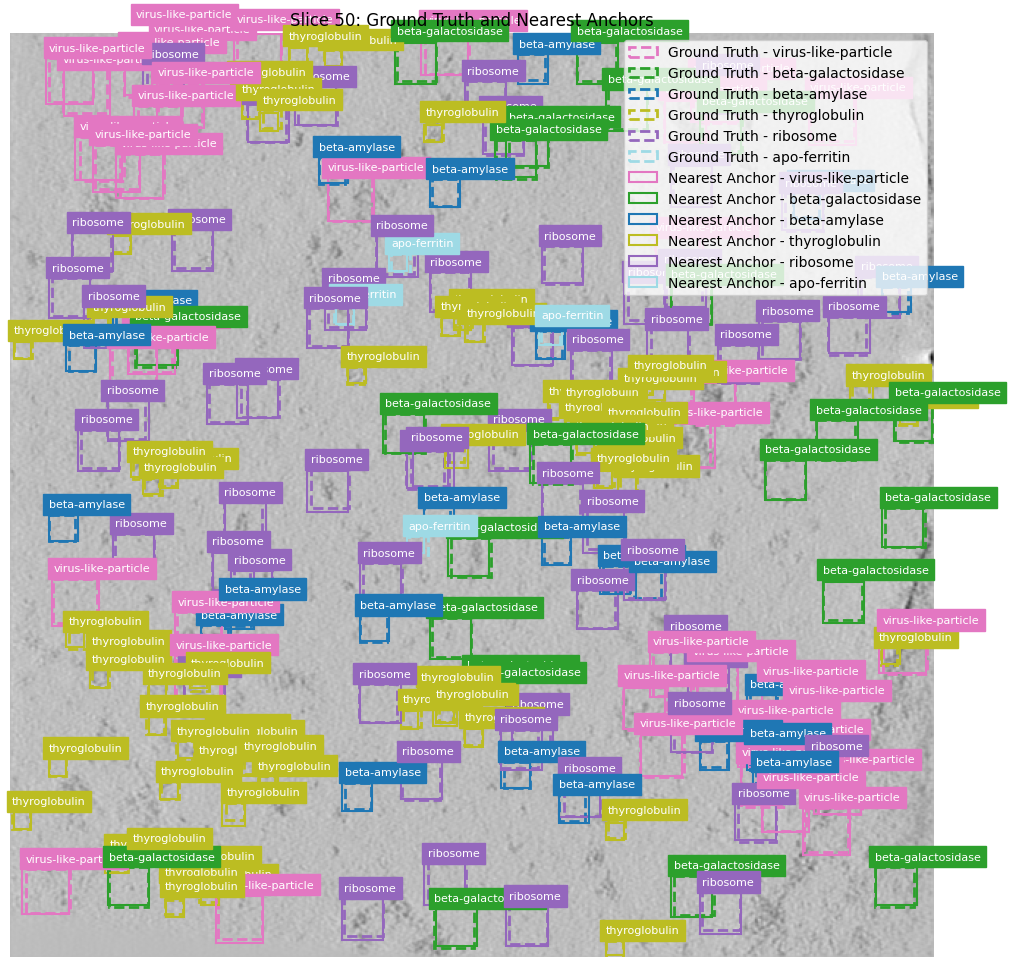

In [500]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial import cKDTree
from tqdm import tqdm
import matplotlib.cm as cm

def compute_box_center(box):
    """
    Computes the center coordinates of a bounding box.

    Args:
        box (np.ndarray): Array of shape (6,) representing 
                          (x_min, y_min, z_min, x_max, y_max, z_max).

    Returns:
        tuple: (x_center, y_center, z_center)
    """
    x_min, y_min, z_min, x_max, y_max, z_max = box
    return ((x_min + x_max) / 2.0, 
            (y_min + y_max) / 2.0, 
            (z_min + z_max) / 2.0)

def compute_iou(anchor_box, gt_box):
    """
    Computes IoU between a single anchor box and a single ground truth box.

    Args:
        anchor_box (np.ndarray): Anchor box coordinates (6,).
        gt_box (np.ndarray): Ground truth box coordinates (6,).

    Returns:
        float: IoU value.
    """
    # Compute intersection coordinates
    x_min_inter = max(anchor_box[0], gt_box[0])
    y_min_inter = max(anchor_box[1], gt_box[1])
    z_min_inter = max(anchor_box[2], gt_box[2])
    x_max_inter = min(anchor_box[3], gt_box[3])
    y_max_inter = min(anchor_box[4], gt_box[4])
    z_max_inter = min(anchor_box[5], gt_box[5])

    # Compute intersection volume
    inter_w = max(0, x_max_inter - x_min_inter)
    inter_h = max(0, y_max_inter - y_min_inter)
    inter_d = max(0, z_max_inter - z_min_inter)
    intersection = inter_w * inter_h * inter_d

    # Compute volumes
    volume_anchor = (anchor_box[3] - anchor_box[0]) * \
                    (anchor_box[4] - anchor_box[1]) * \
                    (anchor_box[5] - anchor_box[2])
    volume_gt = (gt_box[3] - gt_box[0]) * \
               (gt_box[4] - gt_box[1]) * \
               (gt_box[5] - gt_box[2])

    # Compute union volume
    union = volume_anchor + volume_gt - intersection
    iou = intersection / max(union, 1e-6)  # Avoid division by zero

    return iou

def filter_anchors_by_slice(anchor_boxes, slice_index):
    """
    Filters anchor boxes that overlap with a specific slice.

    Args:
        anchor_boxes (np.ndarray): Array of shape (N, 6) representing anchor boxes.
        slice_index (int): The slice index to filter anchors.

    Returns:
        tuple: (filtered_anchor_boxes, filtered_indices)
            - filtered_anchor_boxes (np.ndarray): Anchor boxes overlapping the slice.
            - filtered_indices (np.ndarray): Indices of these anchor boxes in the original array.
    """
    overlapping_indices = np.where(
        (anchor_boxes[:, 2] <= slice_index) & (anchor_boxes[:, 5] > slice_index)
    )[0]
    overlapping_anchor_boxes = anchor_boxes[overlapping_indices]
    return overlapping_anchor_boxes, overlapping_indices

def compute_anchor_centers(anchor_boxes):
    """
    Computes the center coordinates of anchor boxes.

    Args:
        anchor_boxes (np.ndarray): Array of shape (N, 6) representing anchor boxes.

    Returns:
        np.ndarray: Array of shape (N, 3) representing (x_center, y_center, z_center) for each anchor.
    """
    x_center = (anchor_boxes[:, 0] + anchor_boxes[:, 3]) / 2.0
    y_center = (anchor_boxes[:, 1] + anchor_boxes[:, 4]) / 2.0
    z_center = (anchor_boxes[:, 2] + anchor_boxes[:, 5]) / 2.0
    anchor_centers = np.stack([x_center, y_center, z_center], axis=1)
    return anchor_centers

def plot_particles_with_nearest_anchors(
    tomogram,
    anchor_boxes,
    ground_truth_boxes,
    ground_truth_labels,
    id_to_label,
    slice_index=50,
    iou_threshold=0.7,
    max_anchors_to_search=100
):
    """
    Plots a tomogram slice with ground truth boxes for all particle types,
    and for each ground truth box, plots the nearest anchor box with IoU >= iou_threshold,
    along with the center point of the anchor box.

    Args:
        tomogram (np.ndarray): 3D tomogram data of shape (D, H, W).
        anchor_boxes (np.ndarray): Array of anchor boxes with shape (N, 6).
        ground_truth_boxes (np.ndarray): Array of ground truth boxes with shape (M, 6).
        ground_truth_labels (np.ndarray): Array of ground truth labels with shape (M,).
        id_to_label (dict): Mapping of integer IDs to particle labels.
        slice_index (int): Index of the slice to visualize.
        iou_threshold (float): Minimum IoU required to select an anchor.
        max_anchors_to_search (int): Maximum number of anchors to check per ground truth box.
    """
    # Compute centers of all anchor boxes
    anchor_centers = compute_anchor_centers(anchor_boxes)  # Shape: (N, 3)

    # Filter anchors overlapping the slice
    filtered_anchor_boxes, filtered_anchor_indices = filter_anchors_by_slice(anchor_boxes, slice_index)
    filtered_anchor_centers = anchor_centers[filtered_anchor_indices]
    print(f"Number of anchors overlapping slice {slice_index}: {filtered_anchor_boxes.shape[0]}")

    if filtered_anchor_boxes.shape[0] == 0:
        print(f"No anchors overlap with slice {slice_index}.")
        return

    # Build KD-Tree from filtered anchor centers
    print("Building KD-Tree for filtered anchor centers...")
    kdtree = cKDTree(filtered_anchor_centers)

    # Find all ground truth boxes overlapping the slice
    overlapping_gt_indices = []
    for gt_idx in range(len(ground_truth_boxes)):
        gt_box = ground_truth_boxes[gt_idx]
        z_min, z_max = gt_box[2], gt_box[5]
        if z_min <= slice_index <= z_max:
            overlapping_gt_indices.append(gt_idx)

    print(f"Number of ground truth boxes overlapping slice {slice_index}: {len(overlapping_gt_indices)}")

    if len(overlapping_gt_indices) == 0:
        print(f"No ground truth boxes overlap with slice {slice_index}.")
        return

    # Initialize data structures to store selected anchors
    selected_anchors = []
    selected_anchor_centers = []
    selected_gt_boxes = []
    selected_gt_labels = []

    # Get unique particle types
    unique_particle_ids = np.unique(ground_truth_labels[overlapping_gt_indices])
    unique_particle_types = [id_to_label.get(pid, "Unknown") for pid in unique_particle_ids]
    unique_particle_types = list(set(unique_particle_types))  # Remove duplicates

    # Assign colors to each particle type
    cmap = cm.get_cmap('tab20', len(unique_particle_types))
    particle_to_color = {ptype: cmap(i) for i, ptype in enumerate(unique_particle_types)}

    best_ious =[]

    # Iterate over all overlapping ground truth boxes
    print("Searching for nearest anchors with sufficient IoU...")
    for gt_idx in tqdm(overlapping_gt_indices, desc="Processing ground truth boxes"):
        gt_box = ground_truth_boxes[gt_idx]
        gt_label = ground_truth_labels[gt_idx]
        particle_type = id_to_label.get(gt_label, "Unknown")

        # Compute center of the ground truth box
        gt_center = compute_box_center(gt_box)

        # Query KD-Tree for nearest anchors, up to max_anchors_to_search
        distances, indices = kdtree.query(gt_center, k=max_anchors_to_search)

        # If only one neighbor is found, wrap in a list
        if np.isscalar(indices):
            indices = [indices]
            distances = [distances]

        # Initialize variables to store the best anchor
        best_iou = 0
        best_anchor_box = None
        best_anchor_center = None

        # Iterate over the found anchors
        for dist, idx in zip(distances, indices):
            anchor_box = filtered_anchor_boxes[idx]
            iou = compute_iou(anchor_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_anchor_box = anchor_box
                best_anchor_center = filtered_anchor_centers[idx]
            if best_iou >= iou_threshold:
                break  # Found a sufficient anchor

        # Check if a sufficient IoU was found
        if best_iou >= iou_threshold:
            selected_anchors.append(best_anchor_box)
            selected_anchor_centers.append(best_anchor_center)
            selected_gt_boxes.append(gt_box)
            selected_gt_labels.append(particle_type)
        else:
            # Optionally, select the best found anchor even if IoU < threshold
            if best_anchor_box is not None:
                selected_anchors.append(best_anchor_box)
                selected_anchor_centers.append(best_anchor_center)
                selected_gt_boxes.append(gt_box)
                selected_gt_labels.append(particle_type)
                
        best_ious.append(best_iou)
        
    print(f'Lowest IOU: {min(best_ious)}')
    print(f'Highest IOU: {max(best_ious)}')
    print(f'Mean IOU: {np.mean(best_ious)}')
    print(f"Total anchors selected: {len(selected_anchors)}")

    # Initialize the plot
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(tomogram[slice_index], cmap='gray')
    ax.set_title(f"Slice {slice_index}: Ground Truth and Nearest Anchors")

    # To avoid duplicate legend entries
    plotted_labels = set()

    # Plot ground truth boxes
    for gt_box, particle_type in zip(selected_gt_boxes, selected_gt_labels):
        x_min, y_min, z_min, x_max, y_max, z_max = gt_box
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle(
            (x_min, y_min),
            width,
            height,
            linewidth=2,
            edgecolor=particle_to_color[particle_type],
            facecolor='none',
            linestyle='--',
            label=f'Ground Truth - {particle_type}' if f'Ground Truth - {particle_type}' not in plotted_labels else ""
        )
        ax.add_patch(rect)
        plotted_labels.add(f'Ground Truth - {particle_type}')
        # Annotate the ground truth box
        ax.text(
            x_min,
            y_min - 5,
            particle_type,
            color='white',
            fontsize=8,
            backgroundcolor=particle_to_color[particle_type]
        )

    # Plot nearest anchor boxes and their centers
    for anchor_box, anchor_center, particle_type in zip(selected_anchors, selected_anchor_centers, selected_gt_labels):
        x_min, y_min, z_min, x_max, y_max, z_max = anchor_box
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle(
            (x_min, y_min),
            width,
            height,
            linewidth=1.5,
            edgecolor=particle_to_color[particle_type],
            facecolor='none',
            linestyle='-',
            label=f'Nearest Anchor - {particle_type}' if f'Nearest Anchor - {particle_type}' not in plotted_labels else ""
        )
        ax.add_patch(rect)
        plotted_labels.add(f'Nearest Anchor - {particle_type}')

        # # Plot the center point
        # ax.plot(
        #     anchor_center[0],
        #     anchor_center[1],
        #     marker='o',
        #     markersize=5,
        #     markeredgecolor='yellow',
        #     markerfacecolor='none',
        #     label=f'Anchor Center - {particle_type}' if f'Anchor Center - {particle_type}' not in plotted_labels else ""
        # )
        # plotted_labels.add(f'Anchor Center - {particle_type}')

    # Create legend without duplicates
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    ax.axis('off')
    plt.show()


# Example Usage:

# Define the slice index you want to visualize
slice_to_visualize = 50  # Adjust based on your tomogram's depth

# Call the visualization function
plot_particles_with_nearest_anchors(
    tomogram=tomograms_train[0]['tomogram'],                # 3D NumPy array
    anchor_boxes=anchor_boxes_tomogram_space,               # NumPy array of shape (N,6)
    ground_truth_boxes=ground_truth_boxes,                  # NumPy array of shape (M,6)
    ground_truth_labels=ground_truth_labels,                # NumPy array of shape (M,)
    id_to_label=id_to_label,                                # Dictionary mapping IDs to labels
    slice_index=slice_to_visualize,
    iou_threshold=0.8,
    max_anchors_to_search=1000  # Adjust as needed
)

In [517]:
import numpy as np
from scipy.spatial import cKDTree
from tqdm import tqdm

def compute_box_center(box):
    x_min, y_min, z_min, x_max, y_max, z_max = box
    return ((x_min + x_max) / 2.0, 
            (y_min + y_max) / 2.0, 
            (z_min + z_max) / 2.0)

def compute_iou(anchor_box, gt_box):
    x_min_inter = max(anchor_box[0], gt_box[0])
    y_min_inter = max(anchor_box[1], gt_box[1])
    z_min_inter = max(anchor_box[2], gt_box[2])
    x_max_inter = min(anchor_box[3], gt_box[3])
    y_max_inter = min(anchor_box[4], gt_box[4])
    z_max_inter = min(anchor_box[5], gt_box[5])

    inter_w = max(0, x_max_inter - x_min_inter)
    inter_h = max(0, y_max_inter - y_min_inter)
    inter_d = max(0, z_max_inter - z_min_inter)
    intersection = inter_w * inter_h * inter_d

    volume_anchor = (anchor_box[3] - anchor_box[0]) * \
                    (anchor_box[4] - anchor_box[1]) * \
                    (anchor_box[5] - anchor_box[2])
    volume_gt = (gt_box[3] - gt_box[0]) * \
               (gt_box[4] - gt_box[1]) * \
               (gt_box[5] - gt_box[2])

    union = volume_anchor + volume_gt - intersection
    iou = intersection / max(union, 1e-6)

    return iou

def compute_anchor_centers(anchor_boxes):
    x_center = (anchor_boxes[:, 0] + anchor_boxes[:, 3]) / 2.0
    y_center = (anchor_boxes[:, 1] + anchor_boxes[:, 4]) / 2.0
    z_center = (anchor_boxes[:, 2] + anchor_boxes[:, 5]) / 2.0
    anchor_centers = np.stack([x_center, y_center, z_center], axis=1)
    return anchor_centers

def find_best_anchors(
    ground_truth_boxes,
    ground_truth_labels,
    anchor_boxes,
    id_to_label,
    iou_threshold=0.7,
    max_anchors_to_search=1000
):
    """
    Iterates over all ground truth boxes and finds the best anchor box with the highest IoU.

    Args:
        ground_truth_boxes (np.ndarray): Array of ground truth boxes with shape (M, 6).
        ground_truth_labels (np.ndarray): Array of ground truth labels with shape (M,).
        anchor_boxes (np.ndarray): Array of anchor boxes with shape (N, 6).
        id_to_label (dict): Mapping of integer IDs to particle labels.
        iou_threshold (float): Minimum IoU required to select an anchor.
        max_anchors_to_search (int): Maximum number of anchors to check per ground truth box.

    Returns:
        tuple:
            best_anchor_boxes (np.ndarray): Array of best anchor boxes for each ground truth box, shape (M, 6).
            best_ious (np.ndarray): Array of IoUs corresponding to each best anchor box, shape (M,).
    """
    # Compute centers of all anchor boxes
    print("Computing centers of all anchor boxes...")
    anchor_centers = compute_anchor_centers(anchor_boxes)  # Shape: (N, 3)

    # Build KD-Tree from all anchor centers
    print("Building KD-Tree for all anchor centers...")
    kdtree = cKDTree(anchor_centers)

    # Initialize lists to store the best anchors and their IoUs
    best_anchor_boxes = []
    best_ious = []

    print("Iterating over all ground truth boxes to find best anchors...")
    for gt_idx in tqdm(range(len(ground_truth_boxes)), desc="Processing ground truth boxes"):
        gt_box = ground_truth_boxes[gt_idx]
        gt_label_id = ground_truth_labels[gt_idx]
        particle_type = id_to_label.get(gt_label_id, "Unknown")

        # Compute center of the ground truth box
        gt_center = compute_box_center(gt_box)  # (x, y, z)

        # Query KD-Tree for nearest anchors, up to max_anchors_to_search
        distances, indices = kdtree.query(gt_center, k=max_anchors_to_search)

        # If only one neighbor is found, wrap in a list
        if np.isscalar(indices):
            indices = [indices]
            distances = [distances]

        # Initialize variables to store the best anchor
        best_iou = 0
        best_anchor_box = None

        # Iterate over the found anchors
        for dist, idx in zip(distances, indices):
            anchor_box = anchor_boxes[idx]
            iou = compute_iou(anchor_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_anchor_box = anchor_box
            if best_iou >= iou_threshold:
                break  # Found a sufficient anchor

        # Check if a sufficient IoU was found
        if best_iou >= iou_threshold:
            best_anchor_boxes.append(best_anchor_box)
            best_ious.append(best_iou)
        else:
            # Optionally, select the best found anchor even if IoU < threshold
            if best_anchor_box is not None:
                best_anchor_boxes.append(best_anchor_box)
                best_ious.append(best_iou)
            else:
                # In case no anchors are found (extremely rare), append NaNs
                best_anchor_boxes.append(np.array([np.nan]*6))
                best_ious.append(np.nan)

    # Convert lists to NumPy arrays
    best_anchor_boxes = np.array(best_anchor_boxes)  # Shape: (M, 6)
    best_ious = np.array(best_ious)  # Shape: (M,)

    print("Completed finding best anchors for all ground truth boxes.")
    return best_anchor_boxes, best_ious

# Example Usage:

# Define your label to ID mapping
id_to_label = {
    0: 'virus-like-particle',
    1: 'beta-galactosidase',
    2: 'beta-amylase',
    3: 'apo-ferritin',
    4: 'thyroglobulin',
    5: 'ribosome',
    # Add other labels as needed
}

# Ensure that your ground_truth_labels are integers corresponding to the keys in id_to_label
# For example:
# ground_truth_labels = np.array([5, 1, 2, 5, 3, ...])

# Call the find_best_anchors function
best_anchor_boxes, best_ious = find_best_anchors(
    ground_truth_boxes=ground_truth_boxes,                # NumPy array of shape (M,6)
    ground_truth_labels=ground_truth_labels,              # NumPy array of shape (M,)
    anchor_boxes=anchor_boxes_tomogram_space,          # NumPy array of shape (N,6)
    id_to_label=id_to_label,                                # Dictionary mapping IDs to labels
    iou_threshold=0.8,                                      # Desired IoU threshold
    max_anchors_to_search=100                               # Adjust based on your dataset
)

# Verify the shapes
print(f"Best Anchor Boxes Shape: {best_anchor_boxes.shape}")  # Should be (M,6)
print(f"Best IoUs Shape: {best_ious.shape}")                  # Should be (M,)

# Example: Inspect the first 5 results
for i in range(5):
    print(f"Ground Truth Box {i}: {ground_truth_boxes[i]}")
    print(f"Best Anchor Box {i}: {best_anchor_boxes[i]}")
    print(f"IoU: {best_ious[i]:.3f}")
    print("-" * 50)


Computing centers of all anchor boxes...
Building KD-Tree for all anchor centers...
Iterating over all ground truth boxes to find best anchors...


Processing ground truth boxes: 100%|██████████| 1269/1269 [00:00<00:00, 2875.77it/s]

Completed finding best anchors for all ground truth boxes.
Best Anchor Boxes Shape: (1269, 6)
Best IoUs Shape: (1269,)
Ground Truth Box 0: [445.1271  45.1066  45.0934 475.1271  75.1066  75.0934]
Best Anchor Box 0: [444.  44.  44. 476.  76.  76.]
IoU: 0.824
--------------------------------------------------
Ground Truth Box 1: [465.3789  30.5425  36.4016 495.3789  60.5425  66.4016]
Best Anchor Box 1: [464.  28.  36. 496.  60.  68.]
IoU: 0.797
--------------------------------------------------
Ground Truth Box 2: [456.5436  67.5374  65.2166 486.5436  97.5374  95.2166]
Best Anchor Box 2: [456.  68.  64. 488. 100.  96.]
IoU: 0.801
--------------------------------------------------
Ground Truth Box 3: [485.3275  63.2745  65.248  515.3275  93.2745  95.248 ]
Best Anchor Box 3: [484.  64.  64. 516.  96.  96.]
IoU: 0.788
--------------------------------------------------
Ground Truth Box 4: [ 56.0459 366.5845 125.5435  86.0459 396.5845 155.5435]
Best Anchor Box 4: [ 56. 364. 124.  88. 396. 156.

(array([ 13.,  43.,  72., 109., 140., 156., 292., 395.,  38.,  11.]),
 array([0.42495461, 0.47493072, 0.52490683, 0.57488294, 0.62485906,
        0.67483517, 0.72481128, 0.77478739, 0.8247635 , 0.87473961,
        0.92471572]),
 <BarContainer object of 10 artists>)

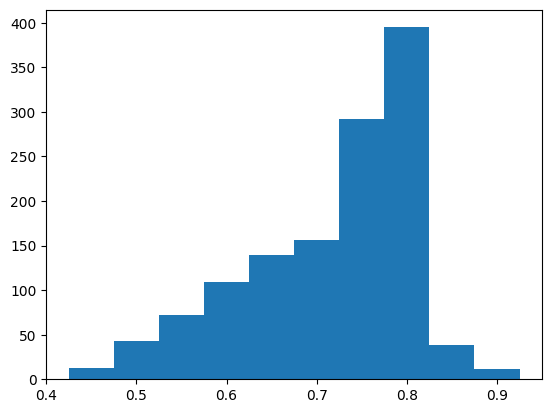

In [518]:
plt.hist(best_ious)

In [526]:
print(best_anchor_boxes[np.argmin(best_ious)])
print(ground_truth_boxes[np.argmin(best_ious)])

[234. 402.  98. 246. 414. 110.]
[232.172 400.032  96.1   244.172 412.032 108.1  ]


In [530]:
compute_iou(ground_truth_boxes[np.argmin(best_ious)],best_anchor_boxes[np.argmin(best_ious)])

np.float64(0.424954611039521)

In [505]:
# :